References:
- https://qiita.com/gensal/items/613d04b5ff50b6413aa0
- https://mbernste.github.io/posts/vae/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc

In [2]:
# Create transform to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# Download MNIST dataset
trainval_data = MNIST(root="./data", train=True, download=True, transform=transform)

# Split data to train and val
train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4)

print("train data size: ",len(train_data))
print("train iteration number: ",len(train_data)//BATCH_SIZE)
print("val data size: ",len(val_data))
print("val iteration number: ",len(val_data)//BATCH_SIZE)

train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


images_size: torch.Size([100, 1, 28, 28])
label: tensor([1, 7, 0, 6, 7, 4, 6, 0, 7, 3, 6, 1, 0, 8, 8, 1, 4, 4, 1, 5, 7, 5, 7, 3,
        1, 9, 8, 3, 2, 7, 3, 1, 9, 5, 4, 0, 2, 5, 8, 6, 0, 5, 6, 1, 6, 7, 5, 5,
        3, 0, 9, 3, 1, 6, 8, 8, 4, 1, 4, 0, 0, 5, 6, 3, 2, 4, 6, 9, 4, 1, 1, 1,
        1, 0, 2, 4, 9, 1, 2, 3, 4, 6, 9, 7, 5, 4, 6, 0, 0, 0, 9, 3, 4, 0, 0, 3,
        7, 5, 3, 7])
100


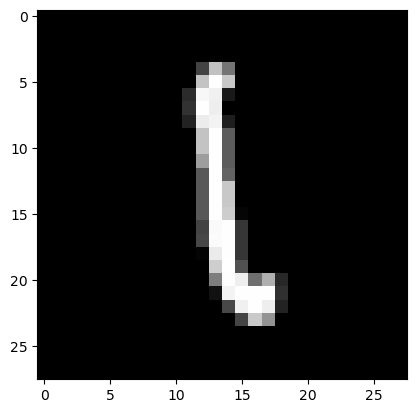

In [3]:
images, labels = next(iter(train_loader)) #Images, labels in first batch.
print("images_size:",images.size()) # [batch_size, channel, height, width]
print("label:",labels)
print(len(labels))

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

Fully connected NN-based VAE

In [9]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.lr = nn.Linear(28*28, 300)
        self.lr2 = nn.Linear(300, 100)
        self.lr_ave = nn.Linear(100, z_dim)
        self.lr_var = nn.Linear(100, z_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.lr2(self.relu(self.lr(x))))
        ave = self.lr_ave(x)
        log_var = self.lr_var(x)

        # Reparameterization Trick
        epsilon = torch.randn_like(ave)
        z = ave + epsilon * torch.exp(log_var / 2)
        return z, ave, log_var

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.lr = nn.Linear(z_dim, 100)
        self.lr2 = nn.Linear(100, 300)
        self.lr3 = nn.Linear(300, 28*28)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lr3(self.relu(self.lr2(self.relu(self.lr(x)))))
        x = torch.sigmoid(x)
        return x

class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    
    def forward(self, x):
        z, ave, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z, ave, log_var
        

In [10]:
def loss_function(output, input, ave, log_var):
	reconstruction_loss = F.binary_cross_entropy(output, input, reduction='sum')
	kl_loss = -0.5 * torch.sum(1 + log_var - ave**2 - log_var.exp())
	loss = reconstruction_loss + kl_loss
	return loss

In [11]:
z_dim = 2
num_epochs = 20

# Check if MPS (Apple GPU support) is available and use it; otherwise, use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: mps


In [12]:
summary = {"train_loss": [], "val_loss": [], "ave": [], "log_var": [], "z": [], "labels": []}

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[15], gamma=0.1)
for epoch in range(num_epochs):
    model.train()
    for batch_num, (x, labels) in enumerate(train_loader):
        input = x.to(device).view(-1, 28*28).to(torch.float32)
        output, z, ave, log_var = model(input)

        summary["ave"].append(ave)
        summary["log_var"].append(log_var)
        summary["z"].append(z)
        summary["labels"].append(labels)
        loss = loss_function(output, input, ave, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_num % 100 == 0:
            print(f'Epoch: {epoch + 1}, loss: {loss:.4f}')
        summary["train_loss"].append(loss)
    
    model.eval()
    with torch.inference_mode():
        for x, labels in val_loader:
            input = x.to(device).view(-1, 28*28).to(torch.float32)
            output, z, ave, log_var = model(input)

            loss = loss_function(output, input, ave, log_var)
            summary["val_loss"].append(loss)
        print(f'Epoch: {epoch + 1}, val_loss: {loss:.4f}')
    
    scheduler.step()


Epoch: 1, loss: 54449.8477
Epoch: 1, loss: 19029.7363
Epoch: 1, loss: 18044.4434
Epoch: 1, loss: 16669.8496
Epoch: 1, loss: 15687.8271
Epoch: 1, val_loss: 17863.7559
Epoch: 2, loss: 16614.5098
Epoch: 2, loss: 16768.6680
Epoch: 2, loss: 17066.2344
Epoch: 2, loss: 16445.2734
Epoch: 2, loss: 15943.1055
Epoch: 2, val_loss: 17138.2637
Epoch: 3, loss: 16203.9805
Epoch: 3, loss: 16239.2100
Epoch: 3, loss: 16837.5918
Epoch: 3, loss: 16644.0273
Epoch: 3, loss: 15356.1035
Epoch: 3, val_loss: 15073.7188
Epoch: 4, loss: 15605.8037
Epoch: 4, loss: 16124.2949
Epoch: 4, loss: 15734.6494
Epoch: 4, loss: 14617.1904
Epoch: 4, loss: 16626.1953
Epoch: 4, val_loss: 14318.8516
Epoch: 5, loss: 14740.7803
Epoch: 5, loss: 15895.0000
Epoch: 5, loss: 16054.6367
Epoch: 5, loss: 15048.0605
Epoch: 5, loss: 14691.3271
Epoch: 5, val_loss: 15076.3555
Epoch: 6, loss: 15079.6172
Epoch: 6, loss: 15815.5059
Epoch: 6, loss: 14217.1709
Epoch: 6, loss: 14470.1992
Epoch: 6, loss: 13879.8291
Epoch: 6, val_loss: 14654.3506
Epoc

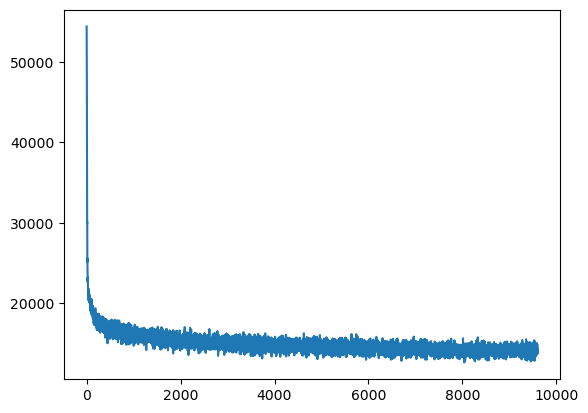

In [13]:
train_loss_tensor = torch.stack(summary["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

確立モデルに潜在変数Zを導入したら複雑な分布をより単純な分布を使って表すことが可能になります。潜在変数を導入することは，同時分布
を設計することに相当します。ここが全ての始まりです。観測データと潜在変数にどのような依存関係があるのかを同時分布として設定してしまうわけです。

変分ベイズを含む従来のベイズ推定の手法では，計算が煩雑になるという欠点があります。一方で，VAEでは近似分布のみならず，真の分布もDNNによって推定しますので，確率的勾配法を用いて一気通貫にパラメータを最適化することができます。

EM algorithm:
 - 潜在変数を含む確率モデルの点推定を行う手法。
 - Mアルゴリズムでは，潜在変数をとパラメータを区別します。
 - EMアルゴリズムではを計算できるという立場を取ります。

Variational Bayes:
 - 変分ベイズは潜在変数を含む確率モデルのベイズ推定を行うための手法です。
 - 潜在変数をとパラメータを区別せずに、両者を一括してZと表します。
 - 変分ベイズではを計算できないという立場を取ります。
 - 変分ベイズは，事後分布を別の新しい分布で近似してしまおうという大胆かつ汎用性の高い手法です。

*Ref: https://academ-aid.com/ml/vae*